# Verification of trends computation method and uncertainties

Compares 2 methods:

1. How it is currently done in [Aerosol trends interface](https://aerocom-trends.met.no/)
2. A modified version of 1. that accounts for certain issues that are disscussed below.

## Functions used in this notebook


All methods used below are defined in file `trends_compare_helpers.py` which should be appended to this notebook.

These include:

- Methods to create a synthetic time-series signal comprising a linear trend, a superimposed seasonal sine pattern with a given frequency and noise. All relevant parameters for the signal can be specified in the following section.
- Methods to compute trend as it is done in the current [Aerosol trends interface](https://aerocom-trends.met.no/). These methods have the ending `_current` (e.g. `compute_trends_current`)
- Methods to compute trend using newly developed methods that are based on previous but aim to improve the accuracy of the trends retrieval. These methods have the ending `_new` (e.g. `compute_trends_new`)
- Some methods for post-processing and plotting of the analysed data.


The names of the functions should be self-explanatory. 

In [1]:
import trends_compare_helpers as h

Initating pyaerocom configuration
Checking database access...
Checking access to: /lustre/storeA
Access to lustre database: True
Init data paths for lustre
Expired time: 0.021 s


## Setup signal details and options

The synthetic signal is plotted a couple of lines below.

In [2]:
# time stuff
START = 2010 # start of timeseries
NUM_YEARS = 15 # number of years
SAMPLING_FREQ = 'D' # time resolution
MIN_DIM = 5 # minimum number of days in month for monthly means

DEFAULT_PERIOD = "{}-{}".format(START, START + NUM_YEARS -1)
SEVEN_YR_PERIOD = "{}-{}".format(START+2, START + 9)
    
# trend signal
DEL_Y_TREND = 3 # between start / stop in variable units
Y_OFFSET = 1

# noise signal
NOISE_AMP = .5 #amplitude of noise (relative to mean value of trend signal)

# superimposed sine signal
PERIODICITY_Y = 1 # periodicity of superimposed sine signale (units of years)
SINE_AMP = 0.5 # amplitude of superimposed sine signal (relative to mean of trend signal)

COVERAGE = 5/31*100 # % for random bootstrapping of timeseries (5 out of 31 days -> ~ 16%)


if not Y_OFFSET > 0:
    raise ValueError('Y_OFFSET needs to be larger than zero')

# Other options

#figure size for plots
FIGS = (16, 8)

DEFAULT_PERIOD, SEVEN_YR_PERIOD

('2010-2024', '2012-2019')

#### Create function shortcuts based on setup

In [3]:
from functools import partial

# Shortcut method to create the signal using the settings specified above
cs = partial(h.create_signal,
             start=START, 
             num_years=NUM_YEARS, 
             sampling_freq=SAMPLING_FREQ, 
             sine_amp=SINE_AMP, 
             freq_periodicity_y=PERIODICITY_Y, 
             del_y_whole_period=DEL_Y_TREND, 
             y_offset=Y_OFFSET, 
             noise_amp=NOISE_AMP)

# Shortcut method to call process_and_plot using the METHODS from the CURRENT trends interface
# (methods are defined in file trends_compare_helpers.py). 
# This method requries 3 input parameters:
#
# 1. A time-series (pandas.Series) supposed to be analysed for trend. It is assumed that this time-series
#    is "complete", that is, it has no missing datapoints in the sampling domain (cf. 2. param. "coverage").
# 2. Parameter "coverage" which is a percentage value between 0 and 100 and specifies how many datapoints
#    are supposed to be randomly removed from the (original, fully sampled) time-series before the trends
#    analysis is performed.
# 3. The time period for which the trend analysis is to be performed (as str, e.g."2010-2020")
#
# The method first randomly removes datapoints from the input time-series (based on input param "coverage"
# and then converts this time-series to monthly applying min_dim (minimum-day-in-month) threshold for 
# resampling and based on that, computes the trends using the newly
# defined methods. 

# It converts this time-series to monthly applying min_dim (minimum-day-in-month) threshold for 
# resampling (as done in current trends interface) and based on that, computes the trends
# (as done in current trends interface). 
pp_current = partial(h.process_and_plot, 
                     min_dim=MIN_DIM, 
                     use_new=False)

# Like previous but using the NEWLY DEVELOPED METHODS for trends computation.
pp_new = partial(h.process_and_plot, 
                 min_dim=MIN_DIM, 
                 use_new=True)

## Compute signal

In [4]:
s0, st = cs() # s0 -> signal, st -> only trend signal (both pandas.Series)

### Compute true trend of whole period

`st` is solely the trend signal. The trend is computed as:

$$
\begin{aligned}
 \mathcal{T}_{rel} &= \Delta v \Delta{t}^{-1} v_{t=t_0}^{-1} \times 100 \\
             &= (v_{t_N} - v_{t_0})(t_N - t_0)^{-1} v_{t_0}^{-1} \times 100
\end{aligned}
$$

where $\mathcal{T}_{rel}$ is the trend (in units of $\%\,yr^{-1}$) for a given time period $\Delta t$ *relative* to the first measured value in that time period. 

**IMPORTANT NOTE**: in the trends interface, the time intervals are provided as `<start_year>-<stop_year` (e.g. `2010-2024`), which is interpreted as the time interval `01.01.2010 - 31.12.2024`, and thus, corresponds to a total *sampling period* of 10 years. However, since the trend as defined above is computed *based on yearly averages* of the input time-series, the total number of years $N$ used for the trends computation is $N=14$ (and not $N=15$). 
Also, the reference values $v_{t_N}$ and $v_{t_0}$ have to be evaluated at the respective mid-year dates (i.e. `15.6.2010 - 15.6.2024`).

In [5]:
TREND_P1 = h.compute_true_trend(st, DEFAULT_PERIOD)
TREND_P1

18.34377540771916

In [6]:
TREND_P2 = h.compute_true_trend(st, SEVEN_YR_PERIOD)
TREND_P2

13.412863614896189

#### TO BE DISCUSSED

From the output above, you can see, that the retrieved trends are different for the 2 time intervals, even though the slope of the signal (i.e. the rate of change) is constant (a linear trend). The reason for that is the normalisation that is done using the first yearly value of the considered period. I (J. Gliss) think this is misleading and should be discussed / reconsidered.

### Plot original synthetic signal and True Trend

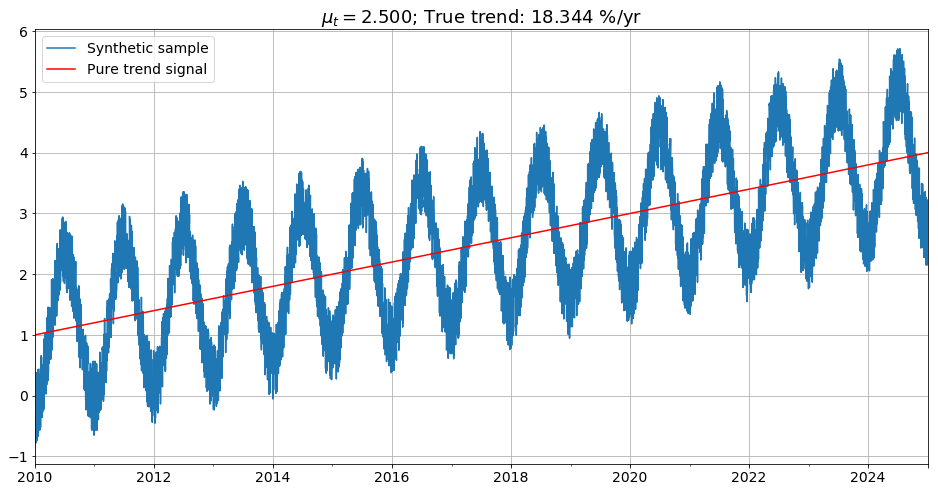

In [7]:
mean = st.mean()

ax = s0.plot(figsize=FIGS, label='Synthetic sample')
st.plot(ax=ax, style='-r', label='Pure trend signal')
ax.grid()
ax.legend()
ax.set_title(r'$\mu_t=${:.3f}; True trend: {:.3f} %/yr'.format(mean, TREND_P1));

## Analysis of trends for different configurations

### Original trend signal (wihout noise and superimposed periodicity)

#### 15 year time interval

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.13252875 1.33240555 1.53278427 1.73263826 1.93249224 2.13236905
 2.33274776 2.53260175 2.73245574 2.93233254 3.13271126 3.33256525
 3.53241924 3.73229604 3.91595182]
(6.337328385147331e-12, -6.95745117722212, 6.337328385147327e-12, 6.337328385147332e-12)


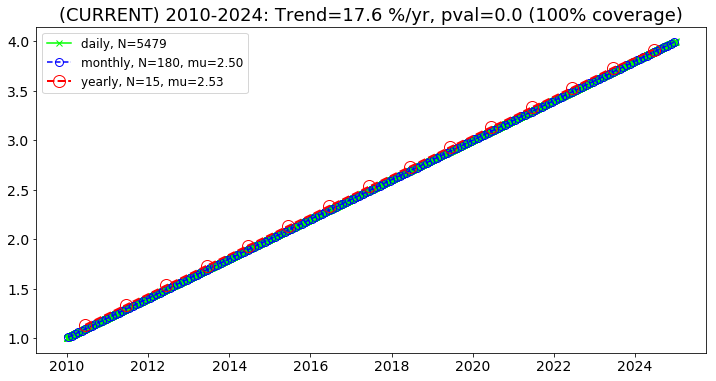

In [8]:
pp_current(st, coverage=100, period=DEFAULT_PERIOD);

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.09921975 1.29907374 1.49940683 1.69932926 1.89918325 2.09903723
 2.29937032 2.49929275 2.69914674 2.89900073 3.09933382 3.29925625
 3.49911024 3.69896423 3.89929732]
(6.337328385147331e-12, -6.990760175214456, 6.337328385147327e-12, 6.337328385147333e-12)


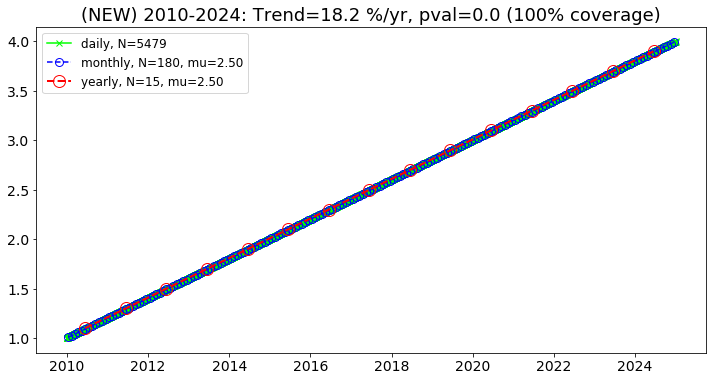

In [9]:
pp_new(st, coverage=100, period=DEFAULT_PERIOD);

#### 7 year time interval

x [1.3397184e+12 1.3712544e+12 1.4027904e+12 1.4343264e+12 1.4659488e+12
 1.4974848e+12 1.5290208e+12 1.5605568e+12]
y [1.53278427 1.73263826 1.93249224 2.13236905 2.33274776 2.53260175
 2.73245574 2.93233254]
(6.3373283851473314e-12, -6.957439770031029, 6.337328385147331e-12, 6.337472993772407e-12)


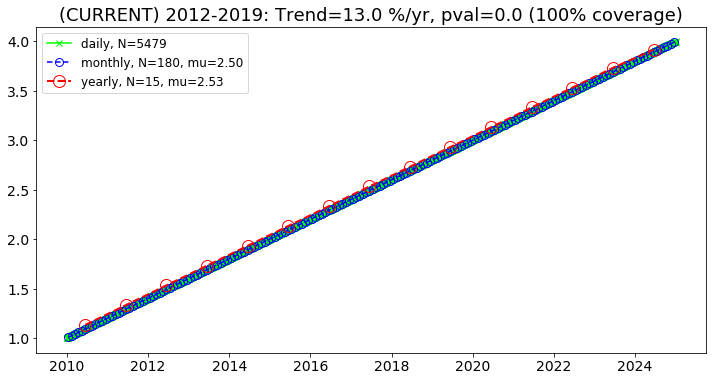

In [10]:
pp_current(st, coverage=100, period=SEVEN_YR_PERIOD);

x [1339718400000 1371254400000 1402790400000 1434326400000 1465948800000
 1497484800000 1529020800000 1560556800000]
y [1.49940683 1.69932926 1.89918325 2.09903723 2.29937032 2.49929275
 2.69914674 2.89900073]
(6.33732838514733e-12, -6.990794396787734, 6.337328385147324e-12, 6.337762211022544e-12)


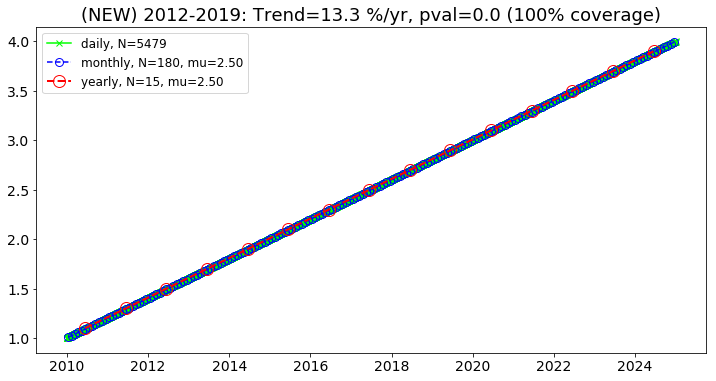

In [11]:
pp_new(st, coverage=100, period=SEVEN_YR_PERIOD);

### Full signal (with noise and superimposed periodicity) 

#### 15 year time interval

##### 100 % coverage

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.11314887 1.32402119 1.51255077 1.74827188 1.90743729 2.15294204
 2.3502094  2.53254022 2.73400593 2.93368819 3.14274639 3.32702454
 3.5658276  3.7223552  4.10327602]
(6.410421936182208e-12, -7.066969187831479, 6.33188276896167e-12, 6.507332455269097e-12)


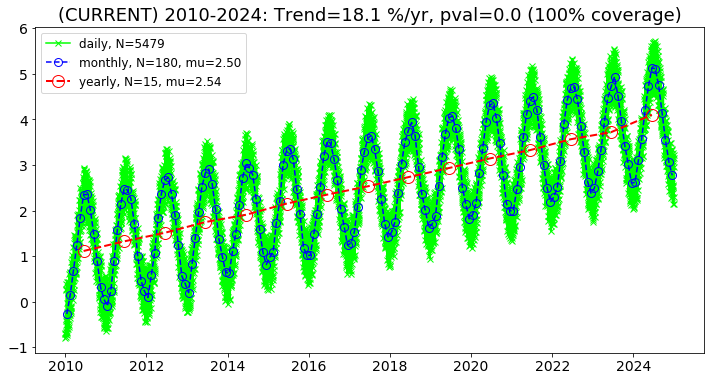

In [12]:
pp_current(s0, coverage=100, period=DEFAULT_PERIOD);

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.09095572 1.27952405 1.48452882 1.68798304 1.88002869 2.11788864
 2.3229137  2.49472776 2.70734774 2.89344725 3.11040729 3.29807379
 3.51962846 3.69274615 3.89612678]
(6.377587161542775e-12, -7.0556120787229295, 6.341501104776361e-12, 6.4315368077953194e-12)


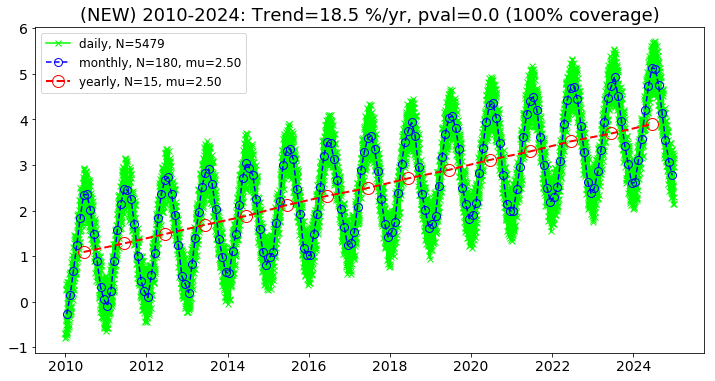

In [13]:
pp_new(s0, coverage=100, period=DEFAULT_PERIOD);

##### 50 % coverage

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.10896741 1.32609941 1.51644287 1.69820878 1.92664451 2.14019718
 2.38831194 2.52038087 2.73878535 2.95948226 3.12762694 3.34259951
 3.53474602 3.7166406  4.09591053]
(6.42953851439606e-12, -7.10775532321747, 6.341928330815701e-12, 6.513634068774663e-12)


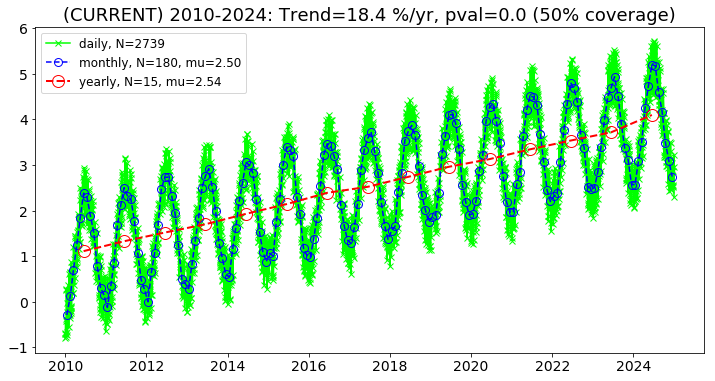

In [14]:
pp_current(s0, coverage=50, period=DEFAULT_PERIOD);

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.10153592 1.26476687 1.50092644 1.69845034 1.87182049 2.1126522
 2.28619296 2.51477212 2.69904521 2.89580658 3.09661826 3.30014348
 3.48068498 3.65531492 3.90044185]
(6.328705130915313e-12, -6.962367621816409, 6.2721330148131964e-12, 6.3830762519134636e-12)


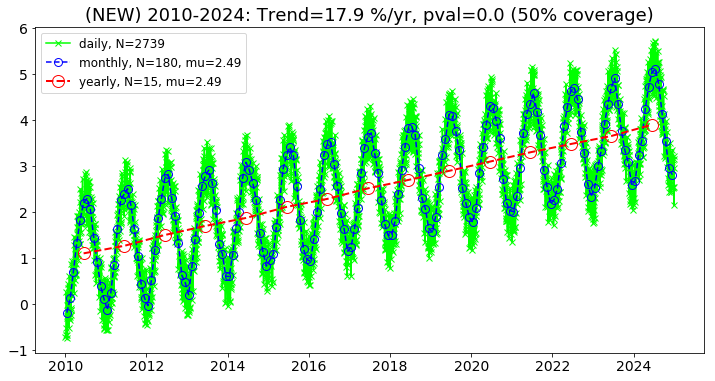

In [15]:
pp_new(s0, coverage=50, period=DEFAULT_PERIOD);

##### 25 % coverage

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.1442411  1.30058129 1.44403079 1.81040381 2.01566281 2.20553022
 2.37425298 2.69387121 2.57421723 2.94390424 3.30742463 3.23339978
 3.43215952 3.80081956 4.15777825]
(6.508720240664204e-12, -7.172492402504213, 6.020656311197811e-12, 6.872099532652512e-12)


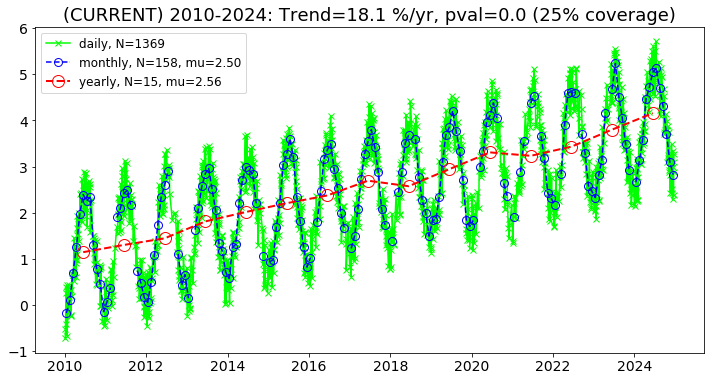

In [16]:
pp_current(s0, coverage=25, period=DEFAULT_PERIOD);

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [0.99539442 1.20339693 1.45753827 1.6924321  1.88712433 2.05212804
 2.34573809 2.49051204 2.7039103  2.85614591 2.9803792  3.43025673
 3.61483988 3.55907665 3.99600136]
(6.7032534524772655e-12, -7.54750811214052, 6.2847726649279585e-12, 6.8742054280587126e-12)


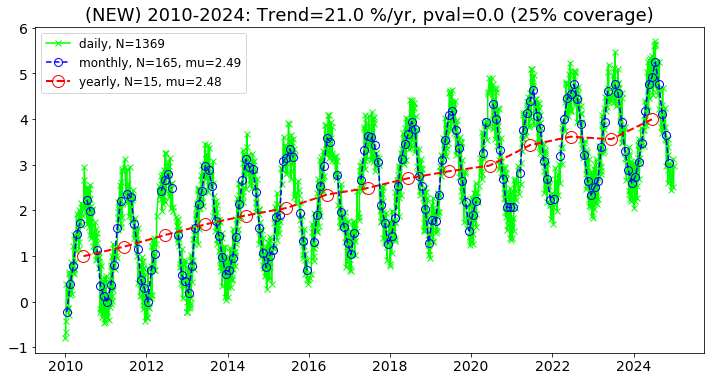

In [17]:
pp_new(s0, coverage=25, period=DEFAULT_PERIOD);

### Interactive plot method

In [18]:
from ipywidgets import interact, fixed
interact(h.process_and_plot, s0=fixed(s0), coverage=(0, 100, 5), period=[DEFAULT_PERIOD, SEVEN_YR_PERIOD], min_dim=(1,15), 
         use_new=[False, True], ax=ax, figsize=fixed(FIGS))

interactive(children=(IntSlider(value=100, description='coverage', step=5), Dropdown(description='period', opt…

<function trends_compare_helpers.process_and_plot(s0, coverage=100, period=None, min_dim=5, use_new=False, figsize=None)>

## Statistical analysis of trends uncertainties

In [19]:
from ipywidgets import IntProgress
import matplotlib.pyplot as plt
pgbar = IntProgress() # instantiate the bar

### 100 % coverage, 100 repititons

IntProgress(value=0)

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.12845027 1.34800138 1.51531078 1.7222046  1.92907392 2.13781369
 2.33149926 2.52367275 2.68963014 2.91481562 3.10928981 3.3429575
 3.51758296 3.76981614 4.10784955]
(6.3653958993237495e-12, -7.008410856684311, 6.278540073571094e-12, 6.490391767493618e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.08285333 1.30768492 1.5624527  1.71509524 1.91447176 2.14172436
 2.32473268 2.48203393 2.69199761 2.92848492 3.13958368 3.32600659
 3.50334559 3.74063775 4.11100911]
(6.427307496477865e-12, -7.142761354129035, 6.324723556894874e-12, 6.557300870188338e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.1546371  1.35183164 1.50398128 1.7245065  1.90995593 2.12875451
 2.35212311 2.53794239 2.72501663 2.95120815 3.11835601 3.31349242
 3.5223375  3.72331158 4.11496259]
(6.33228735522877e-12, -6.944561668933768, 6.2555859237565125e-12, 6.436685838650389e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.11802255 1.32018479 1.52095072 1.74905987 1.91177473 2.10251427
 2.31144383 2.52073134 2.74460938 2.92689093 3.10913339 3.34741786
 3.56925585 3.72528237 4.06653005]
(6.423034682462208e-12, -7.097665467743386, 6.3488517152036e-12, 6.549028781469158e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.1200572  1.32105163 1.51999496 1.72274614 1.94293295 2.12559413
 2.33880296 2.50821584 2.71500038 2.93640397 3.13750701 3.31590573
 3.55765741 3.73669026 4.10351139]
(6.3959413071431326e-12, -7.069609046004455, 6.339885526067137e-12, 6.461027975382391e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.1264741  1.31936047 1.53493159 1.71681909 1.9388479  2.13311443
 2.37279358 2.51483577 2.75265693 2.93672293 3.10036245 3.35336763
 3.5218405  3.73980179 4.13176563]
(6.391596442934512e-12, -7.056482750964751, 6.32190563584873e-12, 6.4823867238465366e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.1341958  1.3285318  1.50582657 1.74252178 1.90325972 2.15667735
 2.36117418 2.54285762 2.75803017 2.94181219 3.1476181  3.32545256
 3.52906357 3.75027037 4.0984577 ]
(6.40335753387891e-12, -7.046072955462993, 6.325383251797142e-12, 6.503154266858532e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.14052717 1.30894971 1.54743486 1.71969363 1.92361654 2.10127605
 2.33550087 2.54079375 2.73385128 2.9092643  3.11781385 3.32713245
 3.55785511 3.70669829 4.0728543 ]
(6.3670827976415045e-12, -6.9938159565245925, 6.278527617967293e-12, 6.478097980430344e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.12065944 1.33162415 1.54409772 1.73119953 1.9134394  2.11637236
 2.31340184 2.51754562 2.73834965 2.93956801 3.10204555 3.31779618
 3.52015324 3.73793713 4.12167784]
(6.355013650809945e-12, -6.99899072722086, 6.304180657552779e-12, 6.4243601802020755e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.16447359 1.31193841 1.52883657 1.70836455 1.91785935 2.13495598
 2.31826065 2.50089237 2.74006147 2.91050423 3.11020264 3.35056239
 3.51161006 3.75693491 4.13788601]
(6.398359975857571e-12, -7.080554442406127, 6.2957434078594085e-12, 6.48502581903023e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.12427724 1.32832561 1.53703616 1.72685959 1.90947775 2.12704171
 2.30717039 2.51920708 2.72026334 2.92483781 3.11816768 3.32263281
 3.49801609 3.71422682 4.11467576]
(6.313451600182718e-12, -6.935090724059941, 6.288024832062362e-12, 6.363442277777046e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.10428748 1.31025255 1.52694005 1.7522931  1.91013143 2.1386944
 2.32522509 2.50303672 2.70947926 2.94918419 3.12947968 3.35015224
 3.53461954 3.72098017 4.09308047]
(6.4177146501962256e-12, -7.107393422223314, 6.333497696367861e-12, 6.531109533198051e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.10241377 1.31057199 1.51868766 1.65896856 1.84653563 2.1172598
 2.29264651 2.50514001 2.67465999 2.91315154 3.10949841 3.31166485
 3.50068459 3.70291553 3.88521371]
(6.326865994254317e-12, -6.969245652329139, 6.2807997482147806e-12, 6.410655713672436e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.08592389 1.32227756 1.46874379 1.6924389  1.89348185 2.0763337
 2.30341962 2.51330549 2.69933214 2.91215791 3.10755514 3.30326988
 3.49369975 3.71919684 3.89067884]
(6.382177965990549e-12, -7.0439090062002165, 6.292997662176432e-12, 6.4232876661105356e-12)
x [1276560000000 1308096000000 1339718400000 

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.12295259 1.29414191 1.48079229 1.70251497 1.91316642 2.06559109
 2.27614049 2.50520468 2.71404467 2.91848599 3.12771439 3.28590798
 3.49745878 3.67432023 3.86019234]
(6.300765909683626e-12, -6.930096498946, 6.21361457794289e-12, 6.400396362963284e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.08788084 1.32995267 1.48931453 1.69191009 1.89403838 2.12272299
 2.26068647 2.48449669 2.6827315  2.90790762 3.11250965 3.30130602
 3.50375403 3.67494874 3.89095064]
(6.321679809576698e-12, -6.982122738079269, 6.261756595061204e-12, 6.3863977199310984e-12)
x [1276560000000 1308096000000 1339718400000 1371

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.10427678 1.29155959 1.5024608  1.71355348 1.93579871 2.10654998
 2.29519429 2.49426516 2.68188298 2.92022807 3.06727558 3.32014516
 3.4761056  3.71433118 3.91586891]
(6.331969954294144e-12, -6.9877635984083595, 6.254959226972957e-12, 6.394266733277379e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.12815879 1.29750724 1.48229787 1.69725295 1.87932993 2.14169706
 2.30534243 2.53384815 2.70704353 2.91382063 3.0682017  3.3060214
 3.50489786 3.70063713 3.89531467]
(6.318170647786223e-12, -6.927516360765594, 6.233013654667119e-12, 6.380163261969289e-12)
x [1276560000000 1308096000000 1339718400000 1

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.10113031 1.2969559  1.48004074 1.70989369 1.87577721 2.08973061
 2.30799414 2.48010381 2.71119888 2.89445633 3.12298069 3.29242601
 3.49813967 3.7264674  3.88356643]
(6.37505479837622e-12, -7.066443850539969, 6.301136226872824e-12, 6.415547835955786e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.09094772 1.30538578 1.48388592 1.68190694 1.88972971 2.06571907
 2.32605371 2.49098386 2.71373785 2.89281414 3.08832486 3.31304861
 3.52412062 3.6373244  3.88734165]
(6.344671557451756e-12, -7.0100653548808785, 6.260127763416383e-12, 6.4198700516011565e-12)
x [1276560000000 1308096000000 1339718400000 

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.13350345 1.29317628 1.50357574 1.71662772 1.87635449 2.09396423
 2.28119334 2.49981016 2.71790439 2.87696255 3.08456467 3.29813207
 3.48490198 3.70590551 3.87715204]
(6.295978302868122e-12, -6.928321647103658, 6.2263879590031256e-12, 6.352451894844796e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.10191834 1.28774612 1.46442751 1.70054445 1.88571384 2.0840332
 2.30238866 2.47593235 2.72234921 2.88841058 3.13327365 3.30380454
 3.50128744 3.6948237  3.88860092]
(6.352250756992859e-12, -7.036466600925408, 6.306857768977658e-12, 6.426380540124307e-12)
x [1276560000000 1308096000000 1339718400000 1

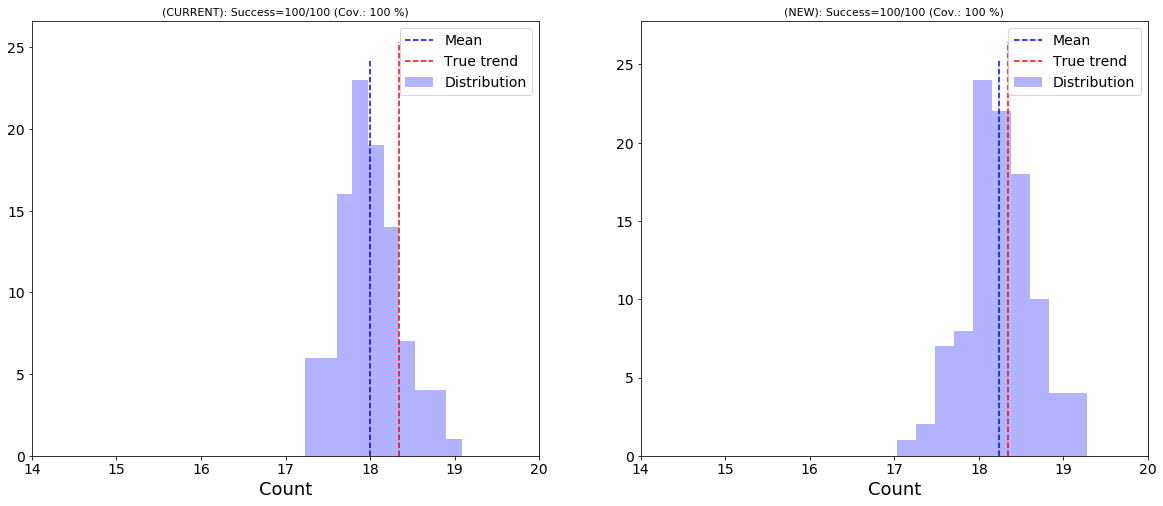

In [20]:
display(pgbar)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
h.run_stat_analysis(signal_func=cs,
                    num=100, 
                    coverage=100, 
                    period=DEFAULT_PERIOD, 
                    min_dim=MIN_DIM,
                    true_trend=TREND_P1,
                    use_new=False,
                    pgbar=pgbar,
                    ax=ax1,
                    xlim=(14, 20))

h.run_stat_analysis(signal_func=cs,
                    num=100, 
                    coverage=100, 
                    period=DEFAULT_PERIOD, 
                    min_dim=MIN_DIM,
                    true_trend=TREND_P1,
                    use_new=True,
                    pgbar=pgbar,
                    ax=ax2,
                    xlim=(14, 20));

### 20 % coverage, 100 repititons

IntProgress(value=100)

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6867872e+12 1.7184096e+12]
y [1.11672316 1.4134009  1.51746689 1.79663742 1.79728775 2.13210725
 2.46153047 2.60051331 2.70708932 2.67869472 3.12063121 3.45671803
 3.5710861  4.14032157]
(6.350151473353222e-12, -6.878104230220803, 5.770885955394242e-12, 6.864873733348956e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4343264e+12
 1.4659488e+12 1.4974848e+12 1.5605568e+12 1.5921792e+12 1.6237152e+12
 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [0.97968047 1.19257907 1.61830665 1.96878269 2.27163187 2.44593497
 2.60655975 2.78219824 2.81723471 3.25968761 3.58708098 3.72333868
 4.04909511]
(6.321732033619593e-12, -6.86013787702576, 5.750226625611808e-12, 6.946740785567764e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.5290208e+12 1.5605

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.05327152 1.31333178 1.27156309 1.66298276 1.77049439 2.13589845
 2.32172348 2.63150939 2.70229453 2.95408586 3.09861968 3.37874492
 3.46678734 3.62100864 3.96227104]
(6.5159686440808294e-12, -7.1260546079217075, 6.20545907389712e-12, 6.796152756151502e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12]
y [1.03840963 1.43657056 1.65931649 1.80474468 1.85436347 1.79767914
 2.31797948 2.41424709 2.6754076  2.92278464 3.19610342 3.26930879
 3.72764099 3.63597519]
(6.297883883819984e-12, -6.9655670684556, 5.803613773732621e-12, 6.836383198964307e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12

x [1.2765600e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12 1.4343264e+12
 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12 1.5921792e+12
 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.03074522 1.37937913 1.8644712  1.90549277 2.29829694 2.60973617
 2.49611873 2.43914798 2.92685862 2.92490514 3.30723768 3.61538089
 3.76231342 4.18672816]
(6.676530846108749e-12, -7.550351545345265, 6.0014090458913214e-12, 7.227809299149196e-12)
x [1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12 1.4343264e+12
 1.4974848e+12 1.5290208e+12 1.5921792e+12 1.6237152e+12 1.6552512e+12
 1.6867872e+12 1.7184096e+12]
y [1.36158354 1.50503699 1.84940222 1.94003881 2.32316704 2.75118238
 2.64670926 3.37908741 3.08953916 3.62285811 3.99243554 4.0512211 ]
(6.6773415285540614e-12, -7.405559943533894, 5.884530474733511e-12, 7.16687456406588e-12)
x [1.2765600e+12 1.3080960e+12 1.3712544e+12 1.4027904e+12 1.4343264e+12
 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12 1.5921792e+12
 1

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.5290208e+12 1.5605568e+12 1.5921792e+12
 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [0.98061544 1.35819401 1.72482569 1.17798089 1.80668527 2.23086778
 2.07347483 2.67080935 2.8493445  3.04690542 3.7243306  3.83866192
 4.26468662]
(6.940162585147829e-12, -7.943055230148491, 6.336916169809142e-12, 8.200888690405538e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4343264e+12
 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12 1.5921792e+12
 1.6237152e+12 1.6552512e+12 1.7184096e+12]
y [1.09618835 1.0142204  1.57777417 1.93057523 2.19463113 2.43323005
 2.29320987 2.7450022  2.8561548  3.44039633 3.22810834 3.60006888
 3.9620095 ]
(6.5030502736228566e-12, -7.304988886271971, 5.851660199114298e-12, 7.377866830823009e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5605568e+12 1.5921792e+12
 

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12 1.5605568e+12
 1.5921792e+12 1.6237152e+12 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.09608247 1.40790324 1.37284267 1.64047793 2.0291599  2.05946374
 2.40059281 2.35941946 2.69718428 3.09492808 3.37000225 3.42832046
 3.56914415 3.59602578 4.03551959]
(6.642976483748417e-12, -7.547163500570801, 6.172934626491121e-12, 7.038268052450343e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.4659488e+12 1.4974848e+12 1.5605568e+12 1.6237152e+12
 1.6552512e+12 1.6867872e+12 1.7184096e+12]
y [1.04703547 1.38743471 1.54990404 1.69221042 2.10256074 2.15041447
 2.38764931 2.63826339 2.89074917 3.20088299 3.70967702 3.63277011
 3.88267448]
(6.2935198017125946e-12, -6.8383284918882214, 5.8783061462503665e-12, 6.844844596541001e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.4343264e+12 1.465

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1655251200000 1686787200000 1718409600000]
y [0.87266059 1.55280329 1.38715199 1.44064932 1.85406087 2.12897572
 2.16264352 2.26465815 2.71420283 2.95145003 3.24914817 3.41210802
 3.9250179  3.92020528]
(6.96172141877357e-12, -8.101648749392549, 6.2642454168947765e-12, 7.493713398790479e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.15791572 1.18790016 1.24524522 1.87334375 1.90722627 2.05535972
 2.18383759 2.26405428 2.54279451 2.82277175 2.80281463 3.29765014
 3.57092406 3.7103639  3.97821718]
(6.475744315652425e-12, -7.433274403955901, 5.8219625760375965e-12, 7.05988443888851e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 140279040000

x [1276560000000 1308096000000 1339718400000 1371254400000 1434326400000
 1465948800000 1497484800000 1529020800000 1560556800000 1592179200000
 1623715200000 1655251200000 1686787200000 1718409600000]
y [0.96443827 1.21785557 1.66591363 1.67542034 1.99119063 2.24274944
 2.63182952 2.69181904 3.10164576 3.00056132 3.31857525 3.52783526
 3.51338309 4.09761831]
(6.622938891177662e-12, -7.360356541340874, 6.061739805831482e-12, 7.091055500715794e-12)
x [1276560000000 1339718400000 1371254400000 1402790400000 1434326400000
 1465948800000 1497484800000 1529020800000 1560556800000 1592179200000
 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.2222033  1.5271442  1.66331316 1.92599975 2.01149346 2.61181147
 2.43027473 2.48094969 2.92537449 3.00177177 3.20540595 3.27601332
 3.66201445 3.83962437]
(5.923782833219943e-12, -6.417800379533968, 5.468247274179695e-12, 6.323813273572036e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 14659488

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [0.92310636 1.53634255 1.16175189 1.74395052 1.94521084 2.18389315
 2.23204117 2.21878213 2.60723981 2.82455265 3.10123989 3.09878043
 3.4949416  3.6766261  3.90352581]
(6.2671510147210625e-12, -7.152922211866085, 5.811406199661815e-12, 6.8445758246284666e-12)
x [1276560000000 1339718400000 1371254400000 1402790400000 1434326400000
 1465948800000 1497484800000 1529020800000 1560556800000 1592179200000
 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.22501577 1.60512827 1.81110374 2.10922543 2.06846521 2.05817165
 2.44646572 2.54321869 3.1409434  2.98291407 3.13013195 3.49823276
 3.69112919 3.85217535]
(5.945823149884579e-12, -6.5026913254657295, 5.369791773097105e-12, 6.539529170117495e-12)
x [1276560000000 1308096000000 1371254400000 1402790400000 143432640

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [0.97034695 1.37217956 1.66157724 1.81048399 2.01146226 2.03986097
 1.99696435 2.67457532 3.05860284 3.0374596  3.07317863 3.43004277
 3.2032189  3.56994384 4.12119039]
(6.420873392502813e-12, -6.940584986212967, 5.591368609549805e-12, 6.876836240454533e-12)
x [1308096000000 1339718400000 1371254400000 1402790400000 1434326400000
 1465948800000 1497484800000 1529020800000 1560556800000 1592179200000
 1623715200000 1655251200000 1686787200000]
y [1.38962765 1.51075577 1.67995293 1.96866689 1.99141522 2.3601854
 2.46013466 2.54445468 2.64457142 2.84344446 3.4198259  3.44960235
 3.65010364]
(5.927245596330445e-12, -6.4158255230226935, 5.1900405412534975e-12, 6.288992828572774e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1529020800000 1560556800000 1592179200000
 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.19913675 1.43579231 1.61857575 1.82504782 2.0677654  2.18919179
 2.29098084 2.63927787 2.82654875 3.40450321 3.35977227 3.10949801
 3.80154978 3.78009458]
(5.848174869000121e-12, -6.292423622726562, 5.425301043962431e-12, 6.275449305447314e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.28188068 1.38564611 1.58032872 1.8774306  1.96786416 2.29894898
 2.2894414  2.49963415 2.34879509 2.81386146 2.92424392 3.03950369
 3.56172113 3.69825528 4.19762338]
(5.7706351691890035e-12, -6.29264335966508, 5.203622715294942e-12, 6.379388143327466e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 140279040000

x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1560556800000 1592179200000
 1623715200000 1655251200000 1686787200000 1718409600000]
y [0.92134499 1.34031694 1.52029762 1.71228244 1.62640746 2.13125226
 2.51836408 2.36099486 3.05685219 2.98955344 3.15848793 3.83684267
 3.76944244 3.86172077]
(6.5196391597096744e-12, -7.220579405471476, 5.805470010226915e-12, 7.332622988203869e-12)
x [1276560000000 1308096000000 1339718400000 1371254400000 1402790400000
 1434326400000 1465948800000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1686787200000 1718409600000]
y [1.09938651 1.53011401 1.54160985 1.65024741 2.0042098  2.02978036
 2.48944766 2.29361888 2.59253914 2.5851618  2.94506485 3.08438234
 3.5945699  3.66932923 3.98512194]
(5.924382215585429e-12, -6.382224652379594, 5.4056057715227165e-12, 6.531035511898623e-12)


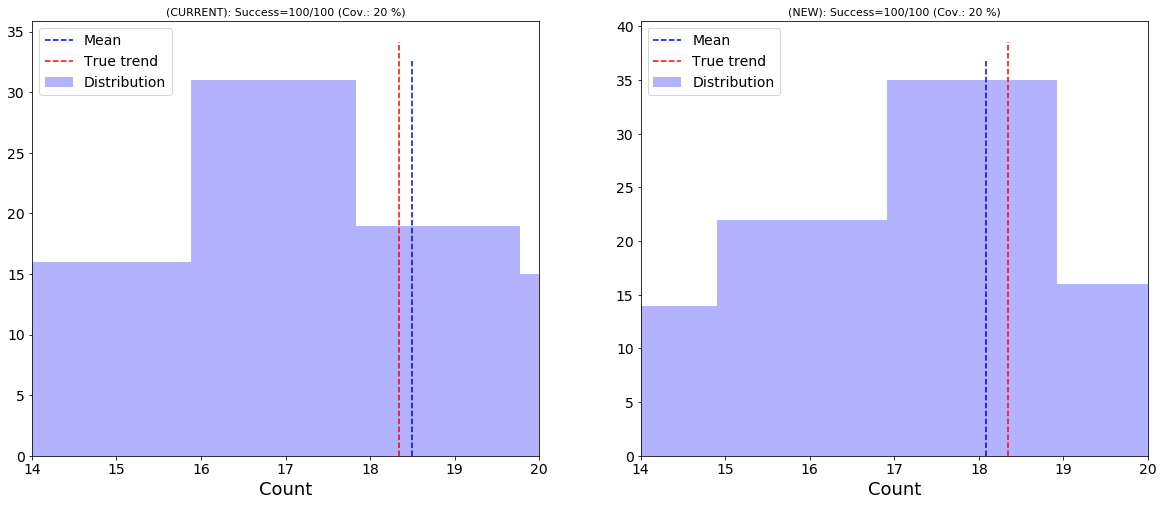

In [21]:
display(pgbar)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
h.run_stat_analysis(signal_func=cs,
                    num=100, 
                    coverage=20, 
                    period=DEFAULT_PERIOD, 
                    min_dim=MIN_DIM,
                    true_trend=TREND_P1,
                    use_new=False,
                    pgbar=pgbar,
                    ax=ax1,
                    xlim=(14, 20))

h.run_stat_analysis(signal_func=cs,
                    num=100, 
                    coverage=20, 
                    period=DEFAULT_PERIOD, 
                    min_dim=MIN_DIM,
                    true_trend=TREND_P1,
                    use_new=True,
                    pgbar=pgbar,
                    ax=ax2,
                    xlim=(14, 20));

### 15 % coverage, 100 repititons

IntProgress(value=100)

x [1.2765600e+12 1.3397184e+12 1.4343264e+12 1.4659488e+12 1.4974848e+12
 1.5290208e+12 1.5605568e+12 1.5921792e+12 1.6867872e+12]
y [1.21773689 1.56229237 2.53740767 2.27455094 2.72038265 2.54580305
 3.0455418  3.10972863 3.87701417]
(6.119689811624657e-12, -6.618339419405322, 5.155364511685803e-12, 7.256270800965714e-12)
x [1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4343264e+12 1.4659488e+12
 1.4974848e+12 1.5605568e+12 1.5921792e+12]
y [0.88590824 2.00743588 1.97368628 2.29514354 2.43256419 2.64940015
 2.78103861 3.05550763]
(4.871333862190687e-12, -4.700250530942322, 3.849271441068054e-12, 7.637197097937283e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.4027904e+12 1.5605568e+12
 1.5921792e+12 1.6867872e+12 1.7184096e+12]
y [1.15629351 1.03639505 1.67996555 1.88841127 3.1075299  2.95255427
 4.11664278 4.34426586]
(7.215713680905345e-12, -8.27084969610538, 5.799852992301478e-12, 8.133930042287218e-12)
x [1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4343264e+12 1.4659488e+12
 1.

x [1.2765600e+12 1.3080960e+12 1.4027904e+12 1.4659488e+12 1.5290208e+12
 1.6237152e+12 1.6867872e+12]
y [1.22241034 1.35716039 2.06300496 2.24030367 2.77042676 3.2641946
 3.666331  ]
(5.95748078733283e-12, -6.493058137907735, 5.437097352796131e-12, 6.457334090133924e-12)
x [1.3080960e+12 1.3397184e+12 1.4027904e+12 1.4974848e+12 1.5290208e+12
 1.5921792e+12 1.6552512e+12 1.6867872e+12]
y [1.28305072 1.70678347 1.40294749 2.44435243 2.53185339 3.32586558
 3.29921263 3.64437422]
(6.183662477439023e-12, -6.869341648216832, 4.675069982079669e-12, 8.943217333541918e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4343264e+12
 1.4659488e+12 1.5290208e+12 1.5605568e+12 1.5921792e+12 1.6237152e+12]
y [0.91645653 1.42253616 1.40715425 1.68875557 1.9883067  1.88168292
 2.27820564 2.78016517 3.41479153 3.47706691]
(6.562428298604022e-12, -7.581429214819632, 4.749351909022765e-12, 7.952273308922176e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4027904e+12
 1.5

x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.3712544e+12 1.4343264e+12
 1.4659488e+12 1.5290208e+12 1.5605568e+12 1.5921792e+12 1.6867872e+12]
y [1.23856596 1.2155632  1.6805987  1.65030083 1.94477078 2.31098249
 3.08835783 2.82134448 3.15770582 3.71723943]
(6.367809835361793e-12, -7.10632383453509, 5.5732266244463695e-12, 6.998795766692639e-12)
x [1.4027904e+12 1.5290208e+12 1.5605568e+12 1.5921792e+12]
y [1.75121004 2.50971577 2.78748054 3.46124457]
(8.918545257378749e-12, -11.128670672106733, 6.0088989940291565e-12, 2.1306543156624268e-11)
x [1.3080960e+12 1.4027904e+12 1.4659488e+12 1.4974848e+12 1.5290208e+12
 1.5605568e+12 1.6237152e+12 1.7184096e+12]
y [1.54473323 2.00674963 2.21675913 2.8225199  2.76778915 2.70688389
 3.08296097 4.30902833]
(5.513240543740368e-12, -5.6055901657877625, 4.257294803805616e-12, 8.137963697772867e-12)
x [1.3080960e+12 1.3712544e+12 1.4027904e+12 1.4974848e+12 1.6237152e+12
 1.6552512e+12 1.7184096e+12]
y [1.4276252  1.79059121 2.02835464 2.5094394

x [1.2765600e+12 1.3712544e+12 1.4027904e+12 1.4343264e+12 1.4974848e+12
 1.6867872e+12]
y [1.2412985  1.80017198 1.89504302 2.41586909 2.68622533 3.66239376]
(5.901864108183934e-12, -6.216682851788866, 4.9374979288782374e-12, 8.355111912852196e-12)
x [1.2765600e+12 1.3080960e+12 1.3397184e+12 1.4659488e+12 1.5290208e+12
 1.5605568e+12 1.5921792e+12 1.6552512e+12 1.6867872e+12]
y [1.25044602 0.98634716 1.61416642 2.11219044 2.75866114 3.06780501
 3.50182165 3.08419052 3.88223507]
(6.558644269487319e-12, -7.269642364156153, 5.134642120172042e-12, 8.244677389248105e-12)
x [1.2765600e+12 1.3397184e+12 1.4027904e+12 1.4659488e+12 1.5290208e+12
 1.5605568e+12 1.5921792e+12 1.6867872e+12 1.7184096e+12]
y [1.38488704 1.44730355 2.12482562 2.10777805 2.60750649 3.00268883
 2.78682625 3.70228343 4.02570456]
(5.919271820985862e-12, -6.44318324662098, 5.232293482873696e-12, 7.220236084251904e-12)
x [1.2765600e+12 1.3080960e+12 1.4027904e+12 1.4343264e+12 1.4974848e+12
 1.5290208e+12 1.5921792e+12

x [1276560000000 1339718400000 1434326400000 1592179200000 1623715200000
 1655251200000 1718409600000]
y [1.25857828 1.72551224 2.31109079 3.0553638  3.27705151 3.50382252
 3.74227417]
(5.6211341804069875e-12, -5.894489122920174, 5.100411020702411e-12, 6.6713350224814835e-12)
x [1339718400000 1402790400000 1497484800000 1529020800000 1560556800000
 1592179200000 1623715200000 1655251200000 1718409600000]
y [1.50073288 1.96001704 2.31297486 2.63469147 2.99449001 3.00094787
 3.30614267 3.53391676 3.90150334]
(6.400400691145247e-12, -6.993698808193988, 5.820074203919464e-12, 7.222668953736311e-12)
x [1276560000000 1308096000000 1402790400000 1465948800000 1497484800000
 1529020800000 1718409600000]
y [0.9641041  1.35389092 1.72748666 2.40861455 2.40241483 2.7402053
 4.06031092]
(6.970346842939745e-12, -7.815756760924192, 6.047533405752984e-12, 7.627222174527845e-12)
x [1276560000000 1339718400000 1402790400000 1465948800000 1560556800000
 1592179200000 1623715200000 1655251200000 17184096

x [1371254400000 1402790400000 1497484800000 1560556800000 1592179200000
 1623715200000 1686787200000]
y [1.82940686 2.248898   2.31924206 2.7864623  3.20320888 3.32219439
 3.46932207]
(5.19728917281482e-12, -5.324202663832343, 3.773005829163268e-12, 7.945410382565904e-12)
x [1276560000000 1308096000000 1339718400000 1434326400000 1465948800000
 1497484800000 1623715200000 1655251200000 1686787200000]
y [1.14235822 1.39349256 1.83500719 2.27989505 2.68797528 2.66702384
 3.27929911 3.78253722 3.85276275]
(6.550606147989357e-12, -6.935829381294996, 5.782081707804083e-12, 7.0706651256849635e-12)
x [1276560000000 1339718400000 1371254400000 1402790400000 1434326400000
 1529020800000 1592179200000 1623715200000 1655251200000 1686787200000]
y [1.38420011 1.13967643 1.89373429 1.6412519  2.18376765 2.50225761
 2.90911546 3.34974709 3.70796846 3.63169823]
(6.441864412952415e-12, -7.201727805452603, 5.068047039915141e-12, 7.733378947788868e-12)
x [1276560000000 1308096000000 1339718400000 14027

x [1339718400000 1371254400000 1402790400000 1434326400000 1465948800000
 1497484800000 1560556800000 1592179200000 1623715200000 1655251200000
 1686787200000 1718409600000]
y [1.13636344 1.89301521 1.50829957 1.84356818 2.44160989 2.46927603
 2.93340665 3.18865261 3.02124536 3.38194598 3.83746246 4.01499851]
(7.056698010407749e-12, -8.088496701974798, 5.918088857626576e-12, 8.071682314688795e-12)
x [1276560000000 1308096000000 1371254400000 1497484800000 1529020800000
 1623715200000 1686787200000 1718409600000]
y [1.3250771  1.15039478 1.8056773  2.24924168 2.48038072 3.15177418
 3.54126576 3.82477159]
(6.097716463444816e-12, -6.862575313302333, 5.261903263136077e-12, 7.098576455052938e-12)
x [1308096000000 1371254400000 1402790400000 1497484800000 1529020800000
 1560556800000 1592179200000 1655251200000]
y [1.32294068 1.42721514 1.80777176 2.43534495 2.6561861  2.79085198
 3.42795427 3.61493368]
(7.1808361844369936e-12, -8.320654939792728, 5.873653945601391e-12, 8.554795819972003e-12

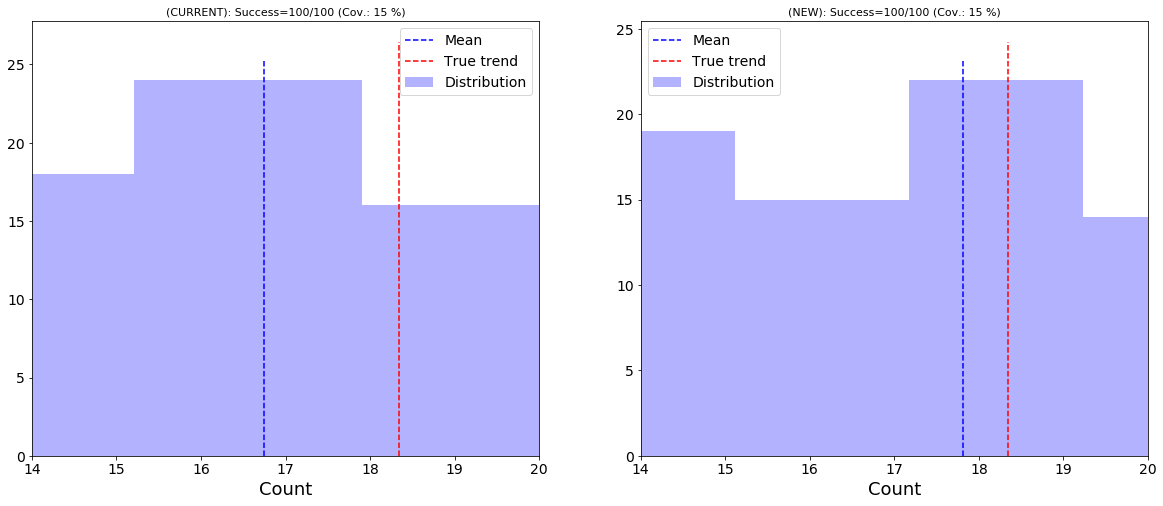

In [22]:
display(pgbar)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
h.run_stat_analysis(signal_func=cs,
                    num=100, 
                    coverage=15, 
                    period=DEFAULT_PERIOD, 
                    min_dim=MIN_DIM,
                    true_trend=TREND_P1,
                    use_new=False,
                    pgbar=pgbar,
                    ax=ax1,
                    xlim=(14, 20))

h.run_stat_analysis(signal_func=cs,
                    num=100, 
                    coverage=15, 
                    period=DEFAULT_PERIOD, 
                    min_dim=MIN_DIM,
                    true_trend=TREND_P1,
                    use_new=True,
                    pgbar=pgbar,
                    ax=ax2,
                    xlim=(14, 20));

### 12 % coverage, 100 repititons

IntProgress(value=100)

x [1.4027904e+12 1.4343264e+12 1.4659488e+12 1.5290208e+12 1.6237152e+12]
y [1.86561585 2.05375414 2.5385465  2.62985072 3.25254695]
(6.180793753041958e-12, -6.522180688479825, 4.525681335174211e-12, 1.0654650018145621e-11)
x [1.4659488e+12 1.5290208e+12 1.6867872e+12]
y [2.40036634 3.02427015 3.46671716]
(4.828647676113568e-12, -4.358832587237166, 2.804443901181232e-12, 9.891929995327877e-12)
x [1.3080960e+12 1.3397184e+12 1.4027904e+12]
y [1.30489832 1.68403909 1.99520758]
(7.289863631568248e-12, -8.082325352382941, 4.9335441186786526e-12, 1.1989626594435477e-11)
x [1.3080960e+12 1.3712544e+12 1.4343264e+12]
y [1.71217848 1.44996611 2.28108418]
(4.506883470063181e-12, -4.467905307914261, -4.151662684955122e-12, 1.3177290647211645e-11)
x [1.3080960e+12 1.5605568e+12 1.6867872e+12]
y [1.0620656  2.91887664 3.74571641]
(7.086646883556897e-12, -8.140238347175416, 6.550242837531057e-12, 7.354848906569816e-12)
x [1.3080960e+12 1.4659488e+12 1.5921792e+12 1.6237152e+12]
y [1.62604612 2.5476

x [1.3397184e+12 1.5290208e+12 1.6552512e+12]
y [1.68411774 2.86540937 3.35240654]
(5.287211969130672e-12, -5.21884770631288, 3.8580022980999415e-12, 6.240235852917024e-12)
x [1.2765600e+12 1.3397184e+12 1.4659488e+12 1.5605568e+12 1.6237152e+12
 1.7184096e+12]
y [1.35312433 1.96517695 2.40765748 2.70292343 3.50318576 4.22581079]
(6.193372371060535e-12, -6.8168476289124875, 3.5053404904479105e-12, 9.647515694632442e-12)
x [1.3080960e+12 1.3712544e+12 1.4974848e+12]
y [1.14119457 1.77431831 2.38534161]
(6.569274595899431e-12, -7.2338283811838675, 4.840539934656265e-12, 1.0024379028288301e-11)
x [1.3397184e+12 1.5290208e+12 1.5921792e+12]
y [1.25161727 2.5034953  3.131661  ]
(7.446873856577909e-12, -8.8829297250087, 6.6131122922648996e-12, 9.945877396126207e-12)
x [1.2765600e+12 1.5290208e+12 1.6867872e+12]
y [1.44633497 2.69513467 4.15308418]
(6.598170983044391e-12, -7.3936060054649175, 4.9465093139021476e-12, 9.241191463457115e-12)
x [1.4027904e+12 1.4974848e+12 1.7184096e+12]
y [2.179

x [1276560000000 1308096000000 1560556800000]
y [1.01417296 1.27757314 2.7442061 ]
(6.091734642483668e-12, -6.691000580809744, 5.809349279936676e-12, 8.352364859914663e-12)
x [1402790400000 1434326400000 1686787200000]
y [1.83734676 1.93780934 3.77393431]
(6.819047076351172e-12, -7.842929900685027, 3.185647704275905e-12, 7.2729111320689924e-12)
x [1308096000000 1371254400000 1402790400000]
y [1.29804361 1.61488858 2.00620809]
(7.478419824919876e-12, -8.63992750850556, 5.016671865660884e-12, 1.2408660258394734e-11)
x [1308096000000 1339718400000 1497484800000 1686787200000]
y [1.54607995 1.39740946 2.66077647 3.68545727]
(5.767577651184955e-12, -6.078466673817225, -4.701429696091098e-12, 8.007833106893269e-12)
x [1276560000000 1402790400000 1560556800000]
y [1.11368562 2.09961972 2.87895735]
(6.215815576782086e-12, -6.619866696736532, 4.9398200765903225e-12, 7.810591609191504e-12)
x [1308096000000 1339718400000 1560556800000]
y [1.30346334 1.46835549 3.08011421]
(7.037333587040742e-12, 

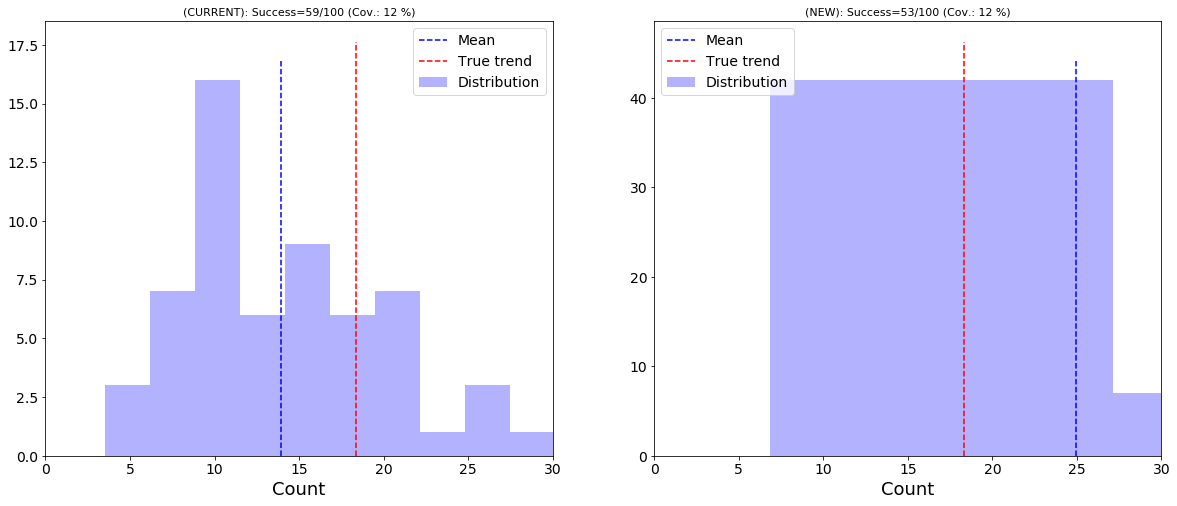

In [23]:
display(pgbar)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
h.run_stat_analysis(signal_func=cs,
                    num=100, 
                    coverage=12, 
                    period=DEFAULT_PERIOD, 
                    min_dim=MIN_DIM,
                    true_trend=TREND_P1,
                    use_new=False,
                    pgbar=pgbar,
                    ax=ax1,
                    xlim=(0, 30))

h.run_stat_analysis(signal_func=cs,
                    num=100, 
                    coverage=12, 
                    period=DEFAULT_PERIOD, 
                    min_dim=MIN_DIM,
                    true_trend=TREND_P1,
                    use_new=True,
                    pgbar=pgbar,
                    ax=ax2,
                    xlim=(0, 30));

## Discussion / Results / Conclusions

### Changes in NEW methods vs. current.

- The current setup uses seasons spring, summer, autumn and winter. The latter is overlapping and starts in Nov. of pervious year until Feb. of current year. This can introduce shifts in the first and last timestamp of the t-series.
- The new method uses 'JFM','AMJ','JAS','OND', which should avoid these problems.
- The current method does not correct for potential situations, where 1. or last time stamp (or both) of yearly series are NaN, when computing the trend (i.e. the computed regression line is evaluated at time-stamps where yearly input data is not NaN). This can result in strong fluctuations in the retrieved relative trend due to the normalisation.
- The new method evaluates the fitted regression line at the actual start / stop time-stamps of the input period.

